# Heart Disease Data Preprocessing

This notebook handles:
1. Data loading and initial cleaning
2. Missing value imputation (KNN)
3. Feature engineering
4. Severity grouping (1-2 → Mild, 3-4 → Severe) for improved class balance
5. Train-test split with stratification
6. Feature scaling
7. Save processed data for modeling

In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
import pickle
import warnings

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Load and Initial Cleaning

In [12]:
# Load dataset
df = pd.read_csv('../data/raw/heart_disease_uci.csv')

print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nFirst few rows:")
display(df.head())

# Remove 'id' column as it's not a feature
df_clean = df.drop(columns=['id', 'dataset'], errors='ignore')
print(f"\nShape after removing ID and dataset columns: {df_clean.shape}")

Dataset Shape: (920, 16)

Columns: ['id', 'age', 'sex', 'dataset', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

First few rows:


,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0



Shape after removing ID and dataset columns: (920, 14)


## 2. Feature Encoding

In [13]:
# Identify feature types
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']
numeric_features = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']

# Encode categorical features
label_encoders = {}
df_encoded = df_clean.copy()

for feature in categorical_features:
    if feature in df_encoded.columns:
        le = LabelEncoder()
        # Handle missing values by treating them as a separate category
        df_encoded[feature] = df_encoded[feature].fillna('Missing')
        df_encoded[feature] = le.fit_transform(df_encoded[feature].astype(str))
        label_encoders[feature] = le

print("Categorical features encoded successfully!")
print(f"\nEncoded features: {list(label_encoders.keys())}")

Categorical features encoded successfully!

Encoded features: ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


## 3. Missing Value Imputation with KNN

In [14]:
# Check missing values before imputation
print("Missing values before imputation:")
missing_before = df_encoded.isnull().sum()
print(missing_before[missing_before > 0])

# Apply KNN imputation
knn_imputer = KNNImputer(n_neighbors=5, weights='uniform')
df_imputed = pd.DataFrame(
    knn_imputer.fit_transform(df_encoded),
    columns=df_encoded.columns,
    index=df_encoded.index
)

# Round categorical features to nearest integer after imputation
for feature in categorical_features:
    if feature in df_imputed.columns:
        df_imputed[feature] = df_imputed[feature].fillna(0).round().astype(int)

print("\nMissing values after imputation:")
print(df_imputed.isnull().sum().sum())
print("\nImputation completed successfully!")

Missing values before imputation:
trestbps     59
chol         30
thalch       55
oldpeak      62
ca          611
dtype: int64

Missing values after imputation:
0

Imputation completed successfully!


## 4. Feature Engineering

In [15]:
# Create new features
df_engineered = df_imputed.copy()

# 1. Age group (binning)
df_engineered['age_group'] = pd.cut(
    df_engineered['age'],
    bins=[0, 40, 50, 60, 70, 100],
    labels=[0, 1, 2, 3, 4]
).fillna(2).astype(int)  # Default to middle category if NaN

# 2. Blood pressure category
df_engineered['bp_category'] = pd.cut(
    df_engineered['trestbps'],
    bins=[0, 120, 140, 160, 300],
    labels=[0, 1, 2, 3]
).fillna(1).astype(int)  # Default to normal-high if NaN

# 3. Cholesterol category
df_engineered['chol_category'] = pd.cut(
    df_engineered['chol'],
    bins=[0, 200, 240, 600],
    labels=[0, 1, 2]
).fillna(1).astype(int)  # Default to borderline-high if NaN

# 4. Heart rate reserve (max HR - resting HR approximation)
df_engineered['hr_reserve'] = df_engineered['thalch'] - (220 - df_engineered['age'])

# 5. Cardiovascular risk score (composite feature)
df_engineered['cv_risk_score'] = (
    df_engineered['age'] / 100 +
    df_engineered['trestbps'] / 200 +
    df_engineered['chol'] / 300 +
    df_engineered['oldpeak'] / 10
)

print("Feature engineering completed!")
print(f"\nNew features created:")
print("  - age_group")
print("  - bp_category")
print("  - chol_category")
print("  - hr_reserve")
print("  - cv_risk_score")
print(f"\nTotal features: {len(df_engineered.columns)}")

Feature engineering completed!

New features created:
  - age_group
  - bp_category
  - chol_category
  - hr_reserve
  - cv_risk_score

Total features: 19


## 5. Group Severity Levels for Better Class Balance

**Grouping Strategy:**
- **Class 0**: No disease (unchanged)
- **Class 1**: Mild disease (original 1-2 grouped together)
- **Class 2**: Severe disease (original 3-4 grouped together)

This reduces the 5-class problem to a 3-class problem, significantly improving class balance while maintaining clinical meaning.

Original target distribution:
num
0.0    411
1.0    265
2.0    109
3.0    107
4.0     28
Name: count, dtype: int64

Grouped target distribution:
num
0.0    411
1.0    374
2.0    135
Name: count, dtype: int64

Class labels:
  0 - No disease
  1 - Mild disease (original 1-2)
  2 - Severe disease (original 3-4)

Binary target distribution:
num
0    411
1    509
Name: count, dtype: int64


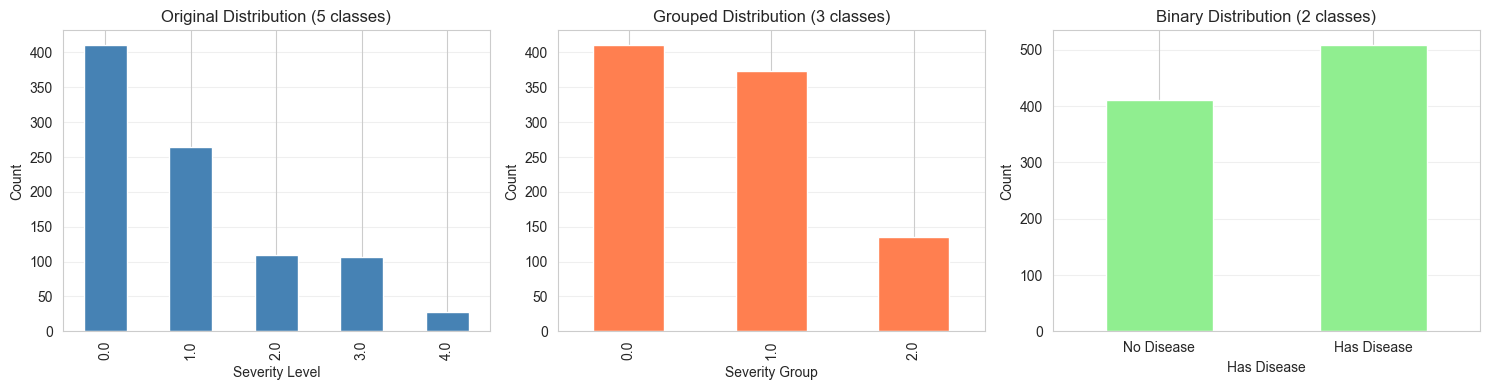


Imbalance analysis:
Original   - Imbalance ratio: 14.68:1
Grouped    - Imbalance ratio: 3.04:1
Binary     - Imbalance ratio: 1.24:1


In [16]:
# Separate features and target
X = df_engineered.drop('num', axis=1)
y = df_engineered['num'].copy()

print("Original target distribution:")
print(y.value_counts().sort_index())

# Create grouped target variable for multi-class
y_grouped = y.copy()
y_grouped = y_grouped.replace({1: 1, 2: 1, 3: 2, 4: 2})  # Group 1-2 as 1, 3-4 as 2

print("\nGrouped target distribution:")
print(y_grouped.value_counts().sort_index())
print("\nClass labels:")
print("  0 - No disease")
print("  1 - Mild disease (original 1-2)")
print("  2 - Severe disease (original 3-4)")

# Create binary target (0 vs any disease)
y_binary = (y > 0).astype(int)

print("\nBinary target distribution:")
print(y_binary.value_counts().sort_index())

# Visualize class distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Original
y.value_counts().sort_index().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Original Distribution (5 classes)')
axes[0].set_xlabel('Severity Level')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', alpha=0.3)

# Grouped
y_grouped.value_counts().sort_index().plot(kind='bar', ax=axes[1], color='coral')
axes[1].set_title('Grouped Distribution (3 classes)')
axes[1].set_xlabel('Severity Group')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', alpha=0.3)

# Binary
y_binary.value_counts().sort_index().plot(kind='bar', ax=axes[2], color='lightgreen')
axes[2].set_title('Binary Distribution (2 classes)')
axes[2].set_xlabel('Has Disease')
axes[2].set_ylabel('Count')
axes[2].set_xticklabels(['No Disease', 'Has Disease'], rotation=0)
axes[2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Check imbalance ratios
print("\nImbalance analysis:")
print("="*60)
for name, target in [('Original', y), ('Grouped', y_grouped), ('Binary', y_binary)]:
    counts = target.value_counts()
    ratio = counts.max() / counts.min()
    print(f"{name:10s} - Imbalance ratio: {ratio:.2f}:1")

## 6. Train-Test Split with Stratification

In [17]:
# Binary classification split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_binary, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y_binary
)

# Multi-class classification split (using grouped targets)
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_grouped, 
    test_size=0.2, 
    random_state=RANDOM_STATE,
    stratify=y_grouped
)

print("Binary Classification Split:")
print(f"  Train: {X_train_bin.shape}, Test: {X_test_bin.shape}")
print(f"  Train distribution: {pd.Series(y_train_bin).value_counts().sort_index().to_dict()}")
print(f"  Test distribution: {pd.Series(y_test_bin).value_counts().sort_index().to_dict()}")

print("\nMulti-class Classification Split (Grouped):")
print(f"  Train: {X_train_multi.shape}, Test: {X_test_multi.shape}")
print(f"  Train distribution: {pd.Series(y_train_multi).value_counts().sort_index().to_dict()}")
print(f"  Test distribution: {pd.Series(y_test_multi).value_counts().sort_index().to_dict()}")

Binary Classification Split:
  Train: (736, 18), Test: (184, 18)
  Train distribution: {0: 329, 1: 407}
  Test distribution: {0: 82, 1: 102}

Multi-class Classification Split (Grouped):
  Train: (736, 18), Test: (184, 18)
  Train distribution: {0.0: 329, 1.0: 299, 2.0: 108}
  Test distribution: {0.0: 82, 1.0: 75, 2.0: 27}


## 7. Feature Scaling

In [18]:
# Standardize features
scaler = StandardScaler()

# Fit on training data only to prevent data leakage
X_train_bin_scaled = pd.DataFrame(
    scaler.fit_transform(X_train_bin),
    columns=X_train_bin.columns,
    index=X_train_bin.index
)

X_test_bin_scaled = pd.DataFrame(
    scaler.transform(X_test_bin),
    columns=X_test_bin.columns,
    index=X_test_bin.index
)

# Use same scaler for multi-class
X_train_multi_scaled = pd.DataFrame(
    scaler.transform(X_train_multi),
    columns=X_train_multi.columns,
    index=X_train_multi.index
)

X_test_multi_scaled = pd.DataFrame(
    scaler.transform(X_test_multi),
    columns=X_test_multi.columns,
    index=X_test_multi.index
)

print("Feature scaling completed!")
print(f"\nScaled feature statistics (sample):")
print(X_train_bin_scaled.describe().iloc[:, :5])

Feature scaling completed!

Scaled feature statistics (sample):
                age           sex            cp      trestbps          chol
count  7.360000e+02  7.360000e+02  7.360000e+02  7.360000e+02  7.360000e+02
mean   3.632360e-16  8.930055e-17  5.551115e-17 -6.106227e-16 -1.472252e-16
std    1.000680e+00  1.000680e+00  1.000680e+00  1.000680e+00  1.000680e+00
min   -2.734186e+00 -1.904975e+00 -8.275708e-01 -2.894287e+00 -1.847090e+00
25%   -7.041962e-01  5.249412e-01 -8.275708e-01 -6.729039e-01 -2.374430e-01
50%    4.369471e-02  5.249412e-01 -8.275708e-01 -1.175582e-01  1.976217e-01
75%    6.847440e-01  5.249412e-01  1.258361e+00  4.377875e-01  6.087716e-01
max    2.501050e+00  5.249412e-01  2.301327e+00  3.769862e+00  3.699295e+00


## 8. Save Processed Data and Artifacts

In [19]:
# Create output directory
import os
os.makedirs('../data/processed', exist_ok=True)

# Save binary classification datasets
X_train_bin_scaled.to_csv('../data/processed/X_train_binary.csv', index=False)
X_test_bin_scaled.to_csv('../data/processed/X_test_binary.csv', index=False)
pd.Series(y_train_bin, name='target').to_csv('../data/processed/y_train_binary.csv', index=False)
pd.Series(y_test_bin, name='target').to_csv('../data/processed/y_test_binary.csv', index=False)

# Save multi-class classification datasets (grouped)
X_train_multi_scaled.to_csv('../data/processed/X_train_multiclass.csv', index=False)
X_test_multi_scaled.to_csv('../data/processed/X_test_multiclass.csv', index=False)
pd.Series(y_train_multi, name='target').to_csv('../data/processed/y_train_multiclass.csv', index=False)
pd.Series(y_test_multi, name='target').to_csv('../data/processed/y_test_multiclass.csv', index=False)

# Save preprocessing artifacts
preprocessing_artifacts = {
    'scaler': scaler,
    'label_encoders': label_encoders,
    'knn_imputer': knn_imputer,
    'feature_names': X.columns.tolist(),
    'numeric_features': numeric_features,
    'categorical_features': categorical_features,
    'severity_grouping': {0: 0, 1: 1, 2: 1, 3: 2, 4: 2},  # Grouping mapping
    'class_names': {0: 'No Disease', 1: 'Mild Disease', 2: 'Severe Disease'}
}

with open('../data/processed/preprocessing_artifacts.pkl', 'wb') as f:
    pickle.dump(preprocessing_artifacts, f)

print("All datasets and artifacts saved successfully!")
print(f"\nSaved files:")
print("Binary Classification:")
print("  - X_train_binary.csv, X_test_binary.csv")
print("  - y_train_binary.csv, y_test_binary.csv")
print("\nMulti-class Classification (Grouped):")
print("  - X_train_multiclass.csv, X_test_multiclass.csv")
print("  - y_train_multiclass.csv, y_test_multiclass.csv")
print("\nPreprocessing Artifacts:")
print("  - preprocessing_artifacts.pkl")

All datasets and artifacts saved successfully!

Saved files:
Binary Classification:
  - X_train_binary.csv, X_test_binary.csv
  - y_train_binary.csv, y_test_binary.csv

Multi-class Classification (Grouped):
  - X_train_multiclass.csv, X_test_multiclass.csv
  - y_train_multiclass.csv, y_test_multiclass.csv

Preprocessing Artifacts:
  - preprocessing_artifacts.pkl


## 9. Summary

In [20]:
print("="*80)
print("DATA PREPROCESSING SUMMARY")
print("="*80)
print(f"\nOriginal dataset: {df.shape}")
print(f"After cleaning: {df_clean.shape}")
print(f"Final feature set: {X.shape}")

print(f"\nFeatures:")
print(f"  - Original features: {len(numeric_features) + len(categorical_features)}")
print(f"  - Engineered features: 5")
print(f"  - Total features: {X.shape[1]}")

print(f"\nTarget Variable Transformation:")
print(f"  - Original classes: 5 (0, 1, 2, 3, 4)")
print(f"  - Grouped classes: 3 (0, 1, 2)")
print(f"  - Grouping: 1-2 → 1 (Mild), 3-4 → 2 (Severe)")

print(f"\nTrain-Test Split:")
print(f"  - Training samples: {len(X_train_bin)} (80%)")
print(f"  - Testing samples: {len(X_test_bin)} (20%)")
print(f"  - Stratification: Applied to maintain class distributions")

print(f"\nPreprocessing Steps Completed:")
print("  - Feature encoding (Label Encoding)")
print("  - Missing value imputation (KNN)")
print("  - Feature engineering (5 new features)")
print("  - Severity grouping for better class balance")
print("  - Train-test split with stratification")
print("  - Feature scaling (StandardScaler)")

print(f"\n{'='*80}")
print("Ready for model training!")
print("="*80)

DATA PREPROCESSING SUMMARY

Original dataset: (920, 16)
After cleaning: (920, 14)
Final feature set: (920, 18)

Features:
  - Original features: 13
  - Engineered features: 5
  - Total features: 18

Target Variable Transformation:
  - Original classes: 5 (0, 1, 2, 3, 4)
  - Grouped classes: 3 (0, 1, 2)
  - Grouping: 1-2 → 1 (Mild), 3-4 → 2 (Severe)

Train-Test Split:
  - Training samples: 736 (80%)
  - Testing samples: 184 (20%)
  - Stratification: Applied to maintain class distributions

Preprocessing Steps Completed:
  - Feature encoding (Label Encoding)
  - Missing value imputation (KNN)
  - Feature engineering (5 new features)
  - Severity grouping for better class balance
  - Train-test split with stratification
  - Feature scaling (StandardScaler)

Ready for model training!
